# DECEPTIVE REVIEW CLASSIFIER

In [1614]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1615]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [1616]:
df.shape

(1600, 5)

In [1617]:
df['deceptive'].value_counts()

deceptive    800
truthful     800
Name: deceptive, dtype: int64

In [1618]:
df['polarity'].value_counts()

negative    800
positive    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [1619]:
df['hotel'].value_counts()

conrad              80
sofitel             80
fairmont            80
hardrock            80
talbott             80
allegro             80
hyatt               80
ambassador          80
knickerbocker       80
monaco              80
homewood            80
swissotel           80
hilton              80
affinia             80
james               80
omni                80
amalfi              80
intercontinental    80
sheraton            80
palmer              80
Name: hotel, dtype: int64

In [1620]:
df['source'].value_counts()

MTurk          800
Web            400
TripAdvisor    400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

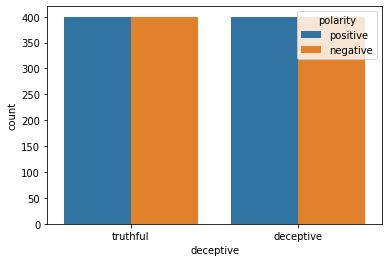

In [1621]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

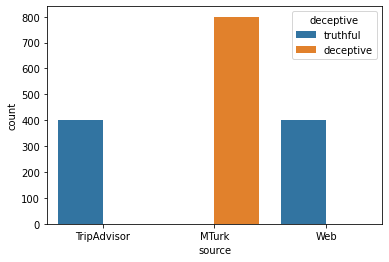

In [1622]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [1623]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [1624]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [1625]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [1626]:
#df['text'] = df['text'].str.replace('Chicago','city')
#df['text'] = df['text'].str.replace('IMO','')

In [1627]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [1628]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [1629]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [1630]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [1631]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [1632]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


In [1633]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [1634]:
df['text']=df['text'].apply(clean_text)
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


In [1635]:
y = df['label']

### FEATURE EXTRACTION USING TFIDF

In [1636]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
#cv=TfidfVectorizer(max_features=21000, ngram_range=(1,3))
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=12000, ngram_range=(1,3))
x=cv.fit_transform(df['text']) 

## MODEL BUILDING

### LINEAR SUPPORT VECTOR MACHINE

In [1637]:
from sklearn.svm import LinearSVC
models = LinearSVC()
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = []
y_exp = []

for train_index, test_index in folds.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    models.fit(x_train, y_train)
    # store result from classification
    y_pred.extend(models.predict(x_test))
    # store expected result for this specific fold
    y_exp.extend(y_test)

print("Accuracy: ",  accuracy_score(y_exp, y_pred))
print(classification_report(y_exp, y_pred))
print("Confusion matrix: ", confusion_matrix(y_exp, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy:  0.878125
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       800
           1       0.88      0.88      0.88       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Confusion matrix:  [[705  95]
 [100 700]]


### PASSIVE AGGRESSIVE CLASSIFIER

In [1638]:
from sklearn.linear_model import PassiveAggressiveClassifier
pag=PassiveAggressiveClassifier(max_iter=1000, random_state=7, tol=1e-3)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = []
y_exp = []

for train_index, test_index in folds.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pag.fit(x_train, y_train)
    # store result from classification
    y_pred.extend(pag.predict(x_test))
    # store expected result for this specific fold
    y_exp.extend(y_test)

print("Accuracy: ",  accuracy_score(y_exp, y_pred))
print(classification_report(y_exp, y_pred))
print("Confusion matrix: ", confusion_matrix(y_exp, y_pred))

Accuracy:  0.883125
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       800
           1       0.89      0.88      0.88       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Confusion matrix:  [[709  91]
 [ 96 704]]


### MULTINOMIAL NAIVE BAYES

In [1639]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha=1.0)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = []
y_exp = []

for train_index, test_index in folds.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mnb.fit(x_train, y_train)
    # store result from classification
    y_pred.extend(mnb.predict(x_test))
    # store expected result for this specific fold
    y_exp.extend(y_test)

print("Accuracy: ",  accuracy_score(y_exp, y_pred))
print(classification_report(y_exp, y_pred))
print("Confusion matrix: ", confusion_matrix(y_exp, y_pred))

Accuracy:  0.884375
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       800
           1       0.90      0.86      0.88       800

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600

Confusion matrix:  [[723  77]
 [108 692]]


### LOGISTIC REGRESSION

In [1640]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000) 
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = []
y_exp = []

for train_index, test_index in folds.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(x_train, y_train)
    # store result from classification
    y_pred.extend(lr.predict(x_test))
    # store expected result for this specific fold
    y_exp.extend(y_test)

print("Accuracy: ",  accuracy_score(y_exp, y_pred))
print(classification_report(y_exp, y_pred))
print("Confusion matrix: ", confusion_matrix(y_exp, y_pred))

Accuracy:  0.8875
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       800
           1       0.89      0.88      0.89       800

    accuracy                           0.89      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600

Confusion matrix:  [[717  83]
 [ 97 703]]


### SUPPORT VECTOR MACHINE

In [1641]:
from sklearn.svm import SVC
model = SVC(C=1.0, kernel='rbf', degree=3)
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = []
y_exp = []

for train_index, test_index in folds.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(x_train, y_train)
    # store result from classification
    y_pred.extend(model.predict(x_test))
    # store expected result for this specific fold
    y_exp.extend(y_test)

print("Accuracy: ",  accuracy_score(y_exp, y_pred))
print(classification_report(y_exp, y_pred))
print("Confusion matrix: ", confusion_matrix(y_exp, y_pred))

Accuracy:  0.861875
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       800
           1       0.86      0.87      0.86       800

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600

Confusion matrix:  [[685 115]
 [106 694]]


### STOCHASTIC GRADIENT DESCENT CLASSIFIER

In [1642]:
from sklearn.linear_model import SGDClassifier
clfs = SGDClassifier()
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y_pred = []
y_exp = []

for train_index, test_index in folds.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clfs.fit(x_train, y_train)
    # store result from classification
    y_pred.extend(clfs.predict(x_test))
    # store expected result for this specific fold
    y_exp.extend(y_test)

print("Accuracy: ",  accuracy_score(y_exp, y_pred))
print(classification_report(y_exp, y_pred))
print("Confusion matrix: ", confusion_matrix(y_exp, y_pred))

Accuracy:  0.865
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       800
           1       0.88      0.85      0.86       800

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600

Confusion matrix:  [[704  96]
 [120 680]]
